# Capstone 1st classification analysis on desirable Lego sets. 

Apart from trying to predict MSRP for Lego sets, the other aim of the project is to successfully classify Lego sets into categories of being nomal sets or desirable sets. The success criteria is to perform better than the baseline accuracy which is yet to be determined. From the EDA we have concluded that the 'wanted' column will be used as our metric. A threshold value would be set and depending on the counts for each instance in the wanted column, they will be classified as being either desirable or normal. It would be reasonable to start oof with such categorsation.

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, auc, classification_report, confusion_matrix, precision_score, recall_score, f1_score
%matplotlib inline

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Just like what we have done in the regression analysis, we have to clean the data frame in order to perform our analysis

In [2]:
engine = create_engine('postgresql://localhost/capstone')
lego = pd.read_sql('SELECT * FROM lego_cleaned_temp', engine)
lego = lego.drop(['Item_Number','Name','Image_URL','USD_MSRP','query_id','adjust_coef'], axis=1)
theme = pd.get_dummies(lego.Theme, drop_first=True)
subtheme = pd.get_dummies(lego.Subtheme, drop_first=True)
packaging = pd.get_dummies(lego.Packaging, drop_first=True)
availability = pd.get_dummies(lego.Availability, drop_first=True)
theme_grp = pd.get_dummies(lego.theme_grp, drop_first=True)
lego = lego.drop(['Theme','Subtheme','Packaging','Availability','theme_grp'],axis=1)
lego_w_dummies = pd.concat([lego,theme,subtheme,packaging,availability,theme_grp],axis=1)
lego_w_dummies.rating = lego_w_dummies.rating.astype(float)
lego_w_dummies.review_num = lego_w_dummies.review_num.astype(float)

A new column which serve as the classification labels is to be created. At this point we would have to define a threshold line to determine which sets are desirable. This threshold can be set at the 80 percentile hence dividing the data into 2 groups with the top 20% being desriable. This sets our baseline accuracy to 80%. This is becuase if we blindly guess that all instances have a label of 0, we will get an 80% accuracy. Therefore a good model should perform better than this accuracy.

In [3]:
np.percentile(lego.wanted, 80)

1091.0

In [4]:
lego_w_dummies['labels'] = lego_w_dummies.wanted.apply(lambda x:0 if x<1091 else 1)

In [5]:
lego_w_dummies['labels'].value_counts()

0    4832
1    1211
Name: labels, dtype: int64

The next step is to create the features and label matrix respectively

In [6]:
X = lego_w_dummies.drop(['wanted','labels'], axis=1)
y = lego_w_dummies['labels']

For the same reason as in the regression analysis, a train-test split is be carried out in order to prevent overfitting. Again this operation divides the data into a training set and a testing set. This allows us to fit the model with the train data and test it with the unseen test data. Typically the train data would include the majority of instances in the data set to allow good model fit. In this case, it is decided that a 4:1 train-test split to be used.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

The first model to try is Logistic Regression. Similar to Linear Regression used in predicting MSRP, Logistic Regression is also a linear model. It relates the log of odds being positive (label = 1) to the predicting features. The assumption of the the model is that the log of odds varies linearly with the predicting features. The advantage of this model is that it is easy to understand. Also being a linear model it is relatively simple and quick to fit hence is suitable to be used as the first model. 

In [15]:
clf = LogisticRegression()
model = clf.fit(X_train,y_train)
pred = model.predict(X_test)

In [16]:
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.93217535153
ROCAUC:  0.884449369077
             precision    recall  f1-score   support

          0       0.95      0.97      0.96       956
          1       0.86      0.80      0.83       253

avg / total       0.93      0.93      0.93      1209

[[924  32]
 [ 50 203]]


The results above shows that Logistic Regression has a very respectable performance of 93% accuracy. This is complemented with a good ROC score of 0.88. ROC score describes the area under the ROC curve. In the Scikit Learn implementation, the baseline ROC score would be 0.5. That means if you are randomly guessing, the mean ROC score that you would likely to get is very close to 0.5.

Looking at the classification report, it seems that the model is better at classifying labels with 0s than labels with 1s. This is expected because we have much more instances that have a true label of 0. However it should be noted that this train-test split is not stratified. Therefore a model performing well in this case might not perform well in other cases where the data is splitted differently. In order to varify that we have got a stable model, a 10 fold cross validation is carried out with the training data to let us gain more insight.

In [19]:
score = cross_val_score(clf,X_train,y_train,cv=10)
print 'Average accuracy: ',np.mean(score)
print score

Average accuracy:  0.94352692516
[ 0.96280992  0.95661157  0.90909091  0.92975207  0.93801653  0.95041322
  0.93581781  0.97101449  0.95850622  0.92323651]


In [21]:
np.std(score)

0.01856741849456477

The average accuracy is 94.4% with a minimum accuracy of 90.9% and maximum accuracy of 97.1%. The standard deviation is 0.0186 which can be translated to an understanding that 95% of the accuracy is likely to fall between 94.4% +- 3.6%. This is sufficient to prove that our model is relatively stable and should be able to handle unseen data with reasonable performance. However it is still possible to try improving this model.

The first step is to use Grid Search in order to find out the optimum hyper-parameter for Logistic Regression classifier.

In [22]:
params = {'penalty':['l1','l2'], 'C':np.logspace(-2,2,5)}
model = GridSearchCV(clf,params,cv=10).fit(X_train,y_train)
print 'Best parameters: ',model.best_params_
print 'Best accuracy: ',model.best_score_

Best parameters:  {'penalty': 'l1', 'C': 10.0}
Best accuracy:  0.950558543649


In [23]:
model_logreg = model.best_estimator_.fit(X_train,y_train)
pred = model_logreg.predict(X_test)
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.94540942928
ROCAUC:  0.910256834306
             precision    recall  f1-score   support

          0       0.96      0.97      0.97       956
          1       0.88      0.85      0.87       253

avg / total       0.94      0.95      0.95      1209

[[928  28]
 [ 38 215]]


The above analysis demonstrated that by using Grid Search we sucessfully find a better parameter to fit the model. The penalty is set to be 'l1'. This has a very similar effect comparing with Lasso when regression analysis is performed. L1 regularisation has a penalty term related to the absolute values of the coefficients. Like Lasso it is also possible to set coefficients of certain features to 0 which can be considered as automatic feature selection. In Scikit Learn implementaion the penalty term is denoted by a prameter named 'C'. It is inversely proportional to the regularisation coefficient alpha. This means that as 'C' gets larger, alpha gets smaller i.e. less regularisation is applied. Grid Search returned a 'C' value of 10 which is higher than default. This means that for this problem a lower regularisation seems to be beneficial.

The following section demonstates the use of other classifiers and their default parameters as comparisons. 

In [42]:
knn = KNeighborsClassifier()
model = knn.fit(X_train,y_train)
pred = model.predict(X_test)
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.880893300248
ROCAUC:  0.801158069691
             precision    recall  f1-score   support

          0       0.91      0.94      0.93       956
          1       0.74      0.66      0.70       253

avg / total       0.88      0.88      0.88      1209

[[897  59]
 [ 85 168]]


In [36]:
dt = DecisionTreeClassifier()
model = dt.fit(X_train,y_train)
pred = model.predict(X_test)
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.916459884202
ROCAUC:  0.871605586518
             precision    recall  f1-score   support

          0       0.95      0.95      0.95       956
          1       0.80      0.79      0.80       253

avg / total       0.92      0.92      0.92      1209

[[907  49]
 [ 52 201]]


In [37]:
rf = RandomForestClassifier()
model = rf.fit(X_train,y_train)
pred = model.predict(X_test)
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.941273779983
ROCAUC:  0.894562323251
             precision    recall  f1-score   support

          0       0.95      0.97      0.96       956
          1       0.90      0.81      0.85       253

avg / total       0.94      0.94      0.94      1209

[[932  24]
 [ 47 206]]


In [38]:
ab = AdaBoostClassifier()
model = ab.fit(X_train,y_train)
pred = model.predict(X_test)
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.939619520265
ROCAUC:  0.896422842211
             precision    recall  f1-score   support

          0       0.95      0.97      0.96       956
          1       0.88      0.82      0.85       253

avg / total       0.94      0.94      0.94      1209

[[928  28]
 [ 45 208]]


In [39]:
et = ExtraTreesClassifier()
model = et.fit(X_train,y_train)
pred = model.predict(X_test)
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.943755169562
ROCAUC:  0.900491177006
             precision    recall  f1-score   support

          0       0.95      0.97      0.96       956
          1       0.90      0.83      0.86       253

avg / total       0.94      0.94      0.94      1209

[[932  24]
 [ 44 209]]


In [40]:
gb = GradientBoostingClassifier()
model = gb.fit(X_train,y_train)
pred = model.predict(X_test)
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.947063688999
ROCAUC:  0.906943043313
             precision    recall  f1-score   support

          0       0.96      0.98      0.97       956
          1       0.90      0.84      0.87       253

avg / total       0.95      0.95      0.95      1209

[[933  23]
 [ 41 212]]


In [41]:
sv = SVC()
model = sv.fit(X_train,y_train)
pred = model.predict(X_test)
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.795698924731
ROCAUC:  0.535110060033
             precision    recall  f1-score   support

          0       0.80      0.98      0.88       956
          1       0.58      0.09      0.15       253

avg / total       0.76      0.80      0.73      1209

[[940  16]
 [231  22]]


The brief analysis above shows that ensemble methods do have a significant edge in this calssification problem. By look at the performance of the ensebles, it is possible to say that they are on par with the tuned Logistic Regression. Therefore it is decided that Grid Search will be used to further enhance those models.

In [47]:
params = {'n_estimators':[100,1000], 'min_samples_split':[2,5,8]}
model = GridSearchCV(rf,params,cv=10, n_jobs=2).fit(X_train,y_train)
print 'Best parameters: ',model.best_params_
print 'Best accuracy: ',model.best_score_

Best parameters:  {'min_samples_split': 5, 'n_estimators': 1000}
Best accuracy:  0.956971452213


In [48]:
optimised_rf = model.best_estimator_.fit(X_train, y_train)
pred = optimised_rf.predict(X_test)
print 'Accuracy: ',accuracy_score(y_test,pred)
print 'ROCAUC: ',roc_auc_score(y_test,pred)
print classification_report(y_test,pred)
print confusion_matrix(y_test,pred)

Accuracy:  0.955334987593
ROCAUC:  0.92525261713
             precision    recall  f1-score   support

          0       0.97      0.98      0.97       956
          1       0.91      0.87      0.89       253

avg / total       0.95      0.96      0.96      1209

[[934  22]
 [ 32 221]]


In [9]:
from ricky_custom import plot_confusion_matrix

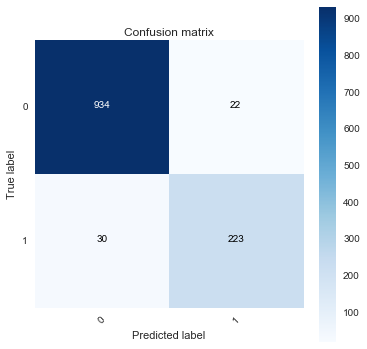

In [10]:
plot_confusion_matrix(confusion_matrix(y_test,pred), classes=optimised_rf.classes_)

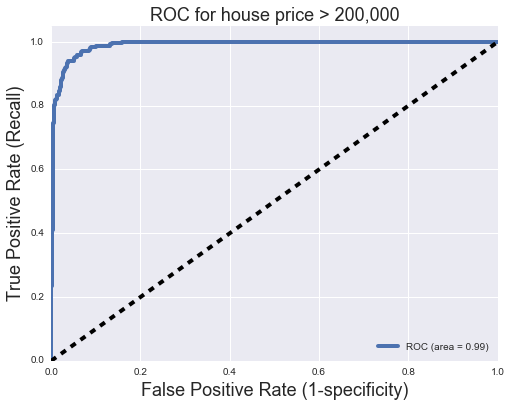

In [12]:
from ricky_custom import plot_roc
plot_roc(y_test,optimised_rf.predict_proba(X_test)[:.1])